# This code post-proceses the sensor reduction results
- model with 12 sensors
- model with 10 sensors
- model with  8 sensors
- model with  6 sensors
- model with  4 sensors

Define the task complete.
(80000, 18)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
(32,)
['case_13', 'case_20', 'case_25', 'case_28']
Done!
Done
Done!


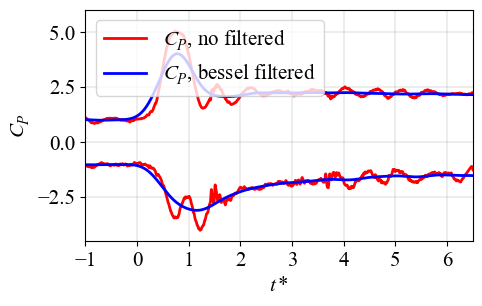

In [1]:
task = 'predict' 
force = 'CL'     
filt = 'bessel' 
ensemble_num = 30

if task == 'cross_validation':
    folds = 7
elif task == 'predict':
    folds = 1
else:
    print('Error. Please define your task.') 
print('Define the task complete.')

# Set the font family to Times New Roman
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'

from keras import backend as K
import numpy as np  #Mathmatical library
import pandas as pd #for data load

import matplotlib.pyplot as plt #Plot
from tqdm import tqdm as tqdm
from scipy.signal import bessel
from scipy.signal import filtfilt

# initialize the data
history_all = {}
predictions_A = {}
predictions_B = {}

# folder path

data_path = '../train_dataframe/gust_dataframe.csv'

# read the excel data
gust_origin = pd.read_csv(data_path)

# set the first column as index, i.e. set case_nn as index, for convenience
gust_origin.set_index('case_number', inplace=True)
print(gust_origin.shape)
# check the first 5 columns
gust_origin.head()

# bessel filter for every column; only filt CP
if filt == 'bessel':
    
    gust_index   = gust_origin.index
    gust_column  = gust_origin.columns
    gust_no_filter = np.zeros((len(set(gust_index.to_list())),len(gust_origin.loc[['case_01']]),len(gust_origin.columns))) # (32,2500,18)
    gust_filter    = np.zeros((len(set(gust_index.to_list())),len(gust_origin.loc[['case_01']]),len(gust_origin.columns)))
    case_all_no = (np.linspace(0,31,32)).astype(int)
    b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)
    
    for i in case_all_no:      # i is the case number
        case_numer = 'case_' + str(i+1).zfill(2)
        gust_no_filter[i] = gust_origin.loc[[case_numer]].to_numpy()
        for j in range(len(gust_origin.columns)-2):       # j is the CP and CL CD number
            gust_filter[i][:,j] = filtfilt(b, a, gust_no_filter[i][:,j])  # bessel for CP
        gust_filter[i][:,len(gust_origin.columns)-2] = gust_no_filter[i][:,len(gust_origin.columns)-2]  # no filter for CL
        gust_filter[i][:,len(gust_origin.columns)-1] = gust_no_filter[i][:,len(gust_origin.columns)-1]  # no filter for CD
    gust = pd.DataFrame(data=np.concatenate(gust_filter,axis=0), index=gust_index, columns=gust_column)
    
elif filt == 'no filter':
    gust = gust_origin
    
else:
    print('Error. Please define your filter.')

# check filter result

T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = (np.arange(0,10000) - 500) / f / T

if filt == 'bessel':
    ii = 13 # case to show
    case_to_show = 'case_' + str(ii).zfill(2)
    cp_to_show   = [-3,-4] # -3 is p0 (stagnation point), -4 is p16(training edge point)
    fig,ax = plt.subplots(figsize=(5,3))
    ax.plot(t_star[0:2500],gust_origin.loc[[case_to_show]].to_numpy()[:,cp_to_show[0]],label='$C_{P}$, no filtered', color='red', linewidth=2)
    ax.plot(t_star[0:2500],gust_origin.loc[[case_to_show]].to_numpy()[:,cp_to_show[1]], color='red', linewidth=2)
    ax.plot(t_star[0:2500],gust.loc[[case_to_show]].to_numpy()[:,cp_to_show[0]],label='$C_{P}$, bessel filtered', color='b', linewidth=2)
    ax.plot(t_star[0:2500],gust.loc[[case_to_show]].to_numpy()[:,cp_to_show[1]], color='b', linewidth=2)
    ax.legend()
    ax.margins(x=0)
    ax.set_xlabel('$t*$')
    ax.set_xticks(np.arange(-1,8))
    ax.set_xlim(-1,6.5)
    ax.set_ylabel('$C_{P}$')
    ax.set_ylim(-4.5,6)
    ax.grid(color='k', linestyle='-', linewidth=0.1)
    
elif filt == 'no filter':
    print('No filter. No compare.')
else:
    print('Error. Please define your filter.')

# fig.savefig('CP_Filter_case_%d_port%d.png' % (ii,0), bbox_inches='tight', dpi=300)
# fig.savefig('CP_Filter_case_%d_port%d.svg' % (ii,0), bbox_inches='tight')

# retrieve CP, 16(CP) + 16(CP_1st_order) + 16(CP_2nd_order) = 48 columns in total
# simply drop CL and CD, then the rest is CP
CP = gust.drop(['CL','CD'],axis=1, inplace=False)
CP.head()

# retrieve CL and CD
CL = gust[['CL']]
CD = gust[['CD']]
gust[[force]].head()

# retrieve for 8 different folds
# read the split .txt file; the number means the cases for test
split_path = '../train_dataframe/delta_wing_32cases_split_random.txt'
with open(split_path, 'r') as file1:    
    fold_split = file1.read().splitlines()       # split by \n
fold_split = fold_split[1:] # drop the head line
for i in range(8):
    fold_split[i] = fold_split[i][9:].split()    # split by space; the number starts from 10th character.
    for j in range(4):
        fold_split[i][j] = int(fold_split[i][j]) # convert string to int
fold_split

# define the 32 case number
case_all_num = np.arange(gust.index.nunique()) + 1
print(case_all_num)
print(case_all_num.shape)

# find the case number for train and test cases;
if task == 'cross_validation':
    train_case = [ [0]*24 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for cross validation folds: fold1~fold7
    for i in range(folds): 
        train_case_temp = np.setdiff1d( case_all_num, np.concatenate((fold_split[i], fold_split[-1]))) 
        # drop test case and the last one (which is for fold 8 , final test)
        test_case_temp  = fold_split[i]

        # conbine to 'case_nn' sample for train and test case; prepare for next step
        for j in range(len(train_case_temp)):
            train_case[i][j] = 'case_' + str(train_case_temp[j]).zfill(2)
        for k in range(len(test_case_temp)):
            test_case[i][k]  = 'case_' + str(test_case_temp[k]).zfill(2)
            
elif task == 'predict': 
    train_case = [ [0]*28 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for test fold: fold8  
    train_case_temp = np.setdiff1d(case_all_num, fold_split[-1])
    test_case_temp  = fold_split[-1]
    for jj in range(len(train_case_temp)):
        train_case[-1][jj] = 'case_' + str(train_case_temp[jj]).zfill(2)
    for kk in range(len(test_case_temp)):
        test_case[-1][kk]  = 'case_' + str(test_case_temp[kk]).zfill(2)

else:
    print('Error. Please define your task.')

print(test_case[0])
print('Done!')

#  prepare for train and test data sets
if task == 'cross_validation':
    F_train_rec = np.zeros([folds,60000,1]) # 24*2500 = 60000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,60000,48])
    P_test_rec  = np.zeros([folds,10000,48])

    for i in range(folds): # 7 folds for training, the last one is for test, not retrieve here, since this is for training
        if force == 'CL':
            F_train_rec[i] = CL.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CL.loc[test_case[i]].to_numpy()
        elif force == 'CD':
            F_train_rec[i] = CD.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CD.loc[test_case[i]].to_numpy()
        else:
            print('Error. Please define force.')

        P_train_rec[i] = CP.loc[train_case[i]].to_numpy()
        P_test_rec[i]  = CP.loc[test_case[i]].to_numpy()

elif task == 'predict':
    F_train_rec = np.zeros([folds,70000,1]) # 28*2500 = 70000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,70000,16])
    P_test_rec  = np.zeros([folds,10000,16])
    
    if force == 'CL':
        F_train_rec[0] = CL.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CL.loc[test_case[0]].to_numpy()
    elif force == 'CD':
        F_train_rec[0] = CD.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CD.loc[test_case[0]].to_numpy()
    else:
        print('Error. Please define force.')

    P_train_rec[0] = CP.loc[train_case[0]].to_numpy()
    P_test_rec[0]  = CP.loc[test_case[0]].to_numpy()
    
else:
    print('Error. Please define your task.')
    
print('Done')

F_train = F_train_rec[0][:,:]   # change to 2d for training
F_test  = F_test_rec[0][:,:]
P_train = P_train_rec[0][:,:]
P_test  = P_test_rec[0][:,:]

print('Done!')

# Read the results

In [2]:
# read prediction history
import pickle

# #Save the variable
# pickle.dump(predictions, open("predictions.dat", "wb"))
# #Load the variable
model_num = [4,6,8,10,12]
result_folder = 'D:/myProject/Exam/Thesis/dashuai/deltaWing/code/2023-04-24-grad-cam-Kai/Grad-CAM-like/Grad-CAM-like/sensor_reduction/result/'
predictions_A = {}
predictions_B = {}
for i in model_num:
    for j in range(30): # 30 is 30 repeated training models; each repeats training 30 times
        predictions_A[i,j] = np.array(pickle.load(open(result_folder+'sensors_'+str(i)+'/model_A_t_0_1/'+
                                                       'pred_ensemble_num_'+str(j)+'.dat', 'rb')))
        predictions_B[i,j] = np.array(pickle.load(open(result_folder+'sensors_'+str(i)+'/model_B_t_0_1/'+
                                                       'pred_ensemble_num_'+str(j)+'.dat', 'rb')))


In [3]:
predictions_A[4,0][0].shape

(10000, 1)

# plot the mse history

In [6]:
from sklearn.metrics import mean_squared_error as mse
epoch_total = 200
mse_pred_per_epoch_A = np.zeros([ensemble_num,epoch_total])
mse_pred_per_epoch_B = np.zeros([ensemble_num,epoch_total])

mse_pred_A = {}
mse_pred_B = {}

for k, sensor in enumerate(model_num):
    print('Processing model: %d' % (sensor))
    for i in range(30):
        mse_pred_A[sensor,i] = []
        mse_pred_B[sensor,i] = []
        for j in range(200):
            mse_pred_A[sensor,i].append(mse(F_test_rec[0][:,:], predictions_A[sensor,i][j][:,0]))
            mse_pred_B[sensor,i].append(mse(F_test_rec[0][:,:], predictions_B[sensor,i][j][:,0]))

Processing model: 4
Processing model: 6
Processing model: 8
Processing model: 10
Processing model: 12


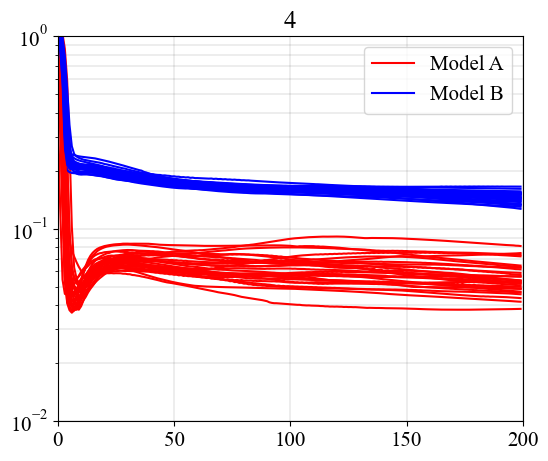

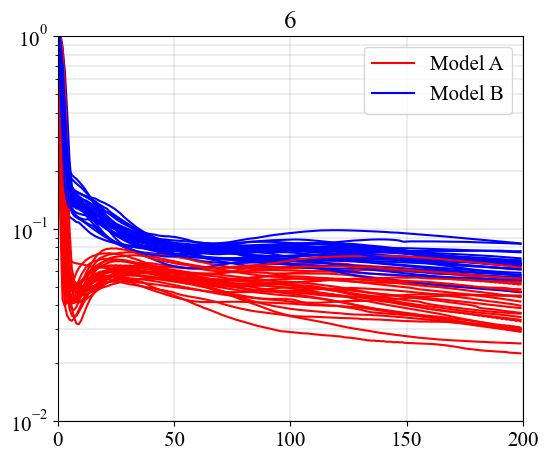

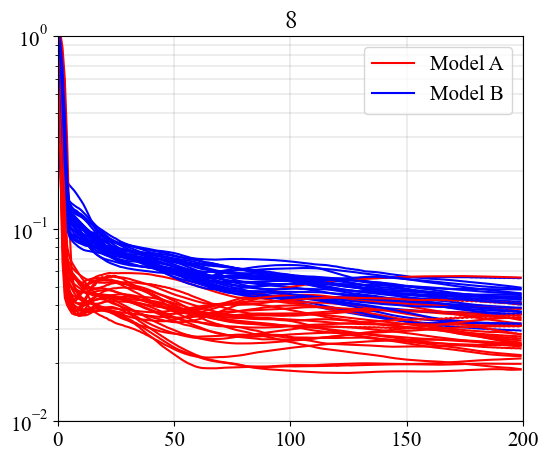

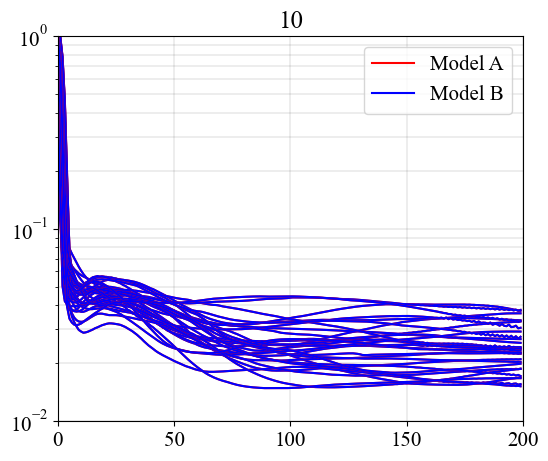

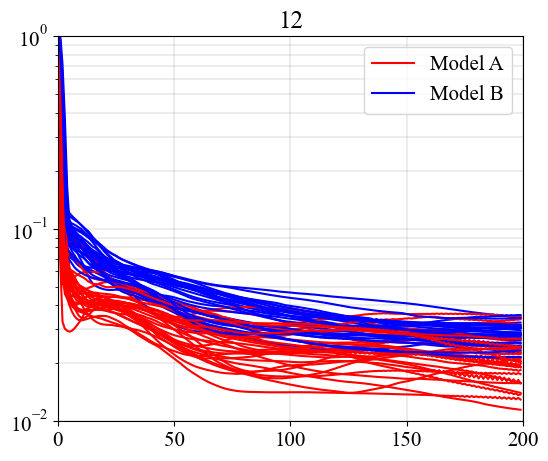

In [7]:
for k, sensor in enumerate(model_num):
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_ylim([0.01, 1])
    ax.set_xlim([0, 200])
    
    for i in range(30):
        ax.semilogy(mse_pred_A[sensor,i], 'red', label='Model A' if i == 0 else None)
        ax.semilogy(mse_pred_B[sensor,i], 'blue', label='Model B' if i == 0 else None)
    ax.grid(which='both', axis='both', color='k', linestyle='-', linewidth=0.1)
    ax.legend()
    ax.set_title(str(sensor))

In [8]:
# this function finds the ensemble average of the epoch predictions and the std  history
# it returns the average result (array) and the std (array)
def ensemble_average(epoch_pred):
    sum_temp = np.zeros((len(epoch_pred[:,0]),len(epoch_pred[0,:])))
    sum_temp[:,0] = epoch_pred[:,0]
    std_hist = np.zeros((len(epoch_pred[0,:])))
    std_hist[0] = np.std(sum_temp[:,0])
    ensemble_averg = np.zeros((len(epoch_pred[:,0]),len(epoch_pred[0,:])))
    ensemble_averg[:,0] = epoch_pred[:,0]
    for i in range(len(epoch_pred[0,:])-1):
        sum_temp[:,i+1] = sum_temp[:,i] + epoch_pred[:,i+1]
        std_hist[i+1] = np.std(sum_temp[:,i+1]/(i+2))
        ensemble_averg[:,i+1] = sum_temp[:,i+1]/(i+2)
    return(std_hist, ensemble_averg)

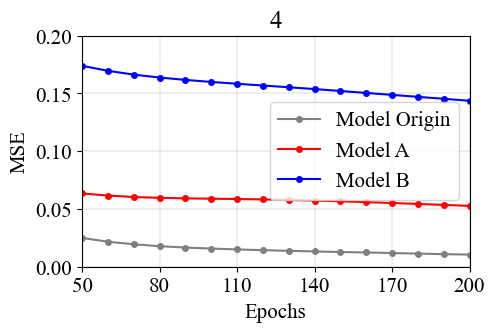

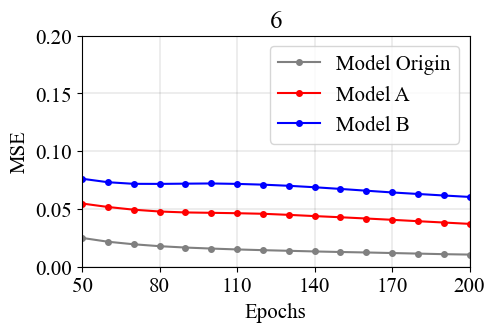

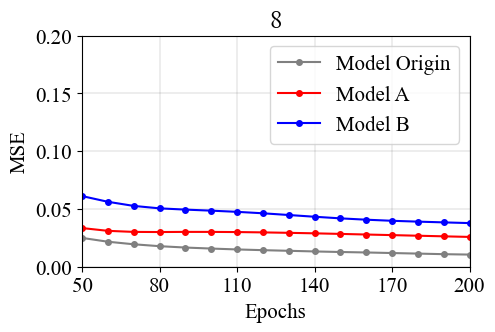

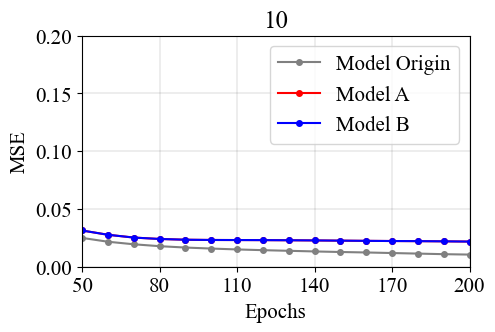

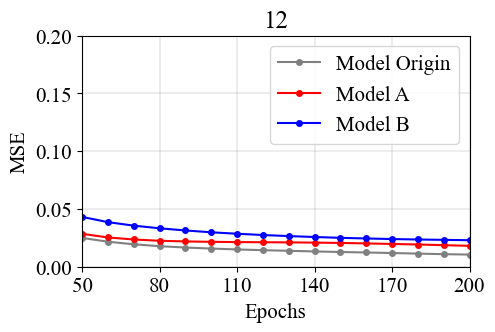

In [33]:
# this cell calcalute the mse of different ensembling average: 50,60,70,80,90,...200

# read the data with 16 sensors
data_16sensors = pd.read_csv('../data_16sensors.csv', header=None).to_numpy()

ensemble_use = np.arange(50,210,10)
mse_ensemble_use_A  = {} # dictionary, with keys and values
mse_ensemble_use_B  = {}
epoch_hist_use_A  = np.zeros([len(ensemble_use),len(F_test_rec[0]),ensemble_num]) # 16*10000*30: 16 to show the mse, 10000 samples, 30 repeats
epoch_hist_use_B  = np.zeros([len(ensemble_use),len(F_test_rec[0]),ensemble_num])
ensemble_avrg_use = {}
ensemble_std_use_A  = {}
ensemble_std_use_B  = {}
ensemble_avrg_use_A = {}
ensemble_avrg_use_B = {}

for sensor in model_num:
    mse_ensemble_use_A[sensor] = []
    mse_ensemble_use_B[sensor] = []
    for j in ensemble_use: # [50,60,70,80,90,...200]
        for i in range(30): # repeat ensemble_num times with same hyperparameters
            epoch_hist_use_A[int(j/10-5),:,i] = predictions_A[sensor, i][j-1][:,0]
            epoch_hist_use_B[int(j/10-5),:,i] = predictions_B[sensor, i][j-1][:,0]

        (ensemble_std_use_A[j], ensemble_avrg_use_A[j]) = ensemble_average(epoch_hist_use_A[int(j/10-5)])
        (ensemble_std_use_B[j], ensemble_avrg_use_B[j]) = ensemble_average(epoch_hist_use_B[int(j/10-5)])

        mse_ensemble_use_A[sensor].append(mse(ensemble_avrg_use_A[j][:,-1], F_test_rec[0][:,:]))
        mse_ensemble_use_B[sensor].append(mse(ensemble_avrg_use_B[j][:,-1], F_test_rec[0][:,:]))

    fig,ax = plt.subplots(figsize=(5,3))
    
    ax.plot(ensemble_use,data_16sensors[:,1],
            color='gray', linewidth=1.5,marker='.',markersize=8, label='Model Origin')
    ax.plot(ensemble_use, mse_ensemble_use_A[sensor],
            color='red', linewidth=1.5,marker='.',markersize=8, label='Model A')
    ax.plot(ensemble_use, mse_ensemble_use_B[sensor],
            color='blue', linewidth=1.5,marker='.',markersize=8, label='Model B')
    ax.set_xlim(50,200)
    ax.set_xticks(np.arange(50,210,30).tolist())
    # ax_use.set_ylim(0.010,0.026)
    ax.grid(color='k', linestyle='-', linewidth=0.1)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE')
    ax.set_ylim([0,0.2])
    ax.legend()
    ax.set_title(str(sensor))
    # fig.savefig('ensemble_error_Filter_neuron%d_layer%d.png' % (neuron_this,layer_this), bbox_inches='tight', dpi=300)
    # fig.savefig('ensemble_error_Filter_neuron%d_layer%d.svg' % (neuron_this,layer_this), bbox_inches='tight')

# Plot the final error together

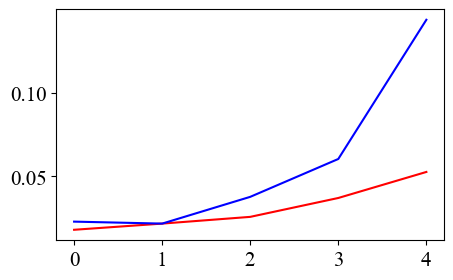

In [43]:
final_error_aggre_A_orignal = []
final_error_aggre_B_orignal = []
for sensor in model_num:
    final_error_aggre_A_orignal.append(mse_ensemble_use_A[sensor][-1])
    final_error_aggre_B_orignal.append(mse_ensemble_use_B[sensor][-1])

# flip the array
final_error_aggre_A = np.flip(final_error_aggre_A_orignal)
final_error_aggre_B = np.flip(final_error_aggre_B_orignal)
    
fig,ax = plt.subplots(figsize=(5,3))

ax.plot(final_error_aggre_A, 'red', label='Model A')
ax.plot(final_error_aggre_B, 'blue', label='Model B')

# ax.set_xticklabels([])